In [1]:
#get MNIST data
#first import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import gzip
import tensorflow as tf
from skimage.transform import downscale_local_mean
import scipy.stats
from tqdm import tqdm





In [2]:
#get the data from keras
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
print('X_train: ' + str(X_train.shape)) #60000 observations, 28 x 28 matrices
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape)) 
print('Y_test:  '  + str(y_test.shape))


X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [3]:
X_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

  0%|          | 0/2 [00:00<?, ?it/s]

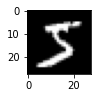

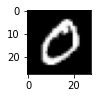

100%|██████████| 2/2 [00:00<00:00, 24.37it/s]


In [4]:
from matplotlib import pyplot
#take a look at a couple of the images for fun
for i in tqdm(range(2)):  
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
    pyplot.show()

In [5]:
factors = (2,2) #2x2 blocks 

#initialize downscaled 3dimensional array
X_train_ds = list()
#for each image in the training data set, downscale by calculating the local mean of each 2x2 block and create a new 14x14 image
for i in range(len(X_train)):
    #downscale the bih
    ith_downscaled_image = downscale_local_mean(X_train[i], factors, cval=0, clip=True)
    
    #append it to downscaled training data
    X_train_ds.append(ith_downscaled_image)
    
#make it a 3 d array
X_train_ds = np.array(X_train_ds)

In [6]:
X_train_ds.shape #seems to have worked, X_train_ds is the downscaled version, each element is a 14 by 14 matrix

#for using in (the EM) algorithm, each sample should be treated as a vector (14x14 = 196 dimensional vector)
X_train_vectorized = X_train_ds.reshape(60000,196)

In [7]:
#for our purposes we only want to consider image 5 image classes: {0,1,2,3,4}
#drop the rest

#find the indices from y_train that are 5,6,7,8,9
bool_arr = (y_train >= 5) #find the indices of the images we don't want to cluster/consider
drop_indices = np.where(bool_arr)

#delete them from y_train
y_train_0_4 = np.delete(y_train, drop_indices)

#delete them from X_train as well
X_train_vectorized_0_4 = np.delete(X_train_vectorized, drop_indices, axis = 0) #drop the correct indices row-wise (axis = 0)
#remember, each row now corresponds to an image

In [8]:
X_train_vectorized_0_4[0]

array([  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,  84.25, 229.  , 174.5 ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   2.5 ,
        84.5 , 246.25, 236.25, 205.25, 109.5 ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  , 113.  , 252.5 , 202.25,
       246.25, 102.75, 210.75,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,  62.75, 244.  , 180.75,  21.75,  35.5 ,   0.  ,
       250.25,  53.75,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,  16.  ,
       233.5 ,  93.5 ,  11.75,   0.  ,   0.  ,   0.  , 252.5 ,  97.5 ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  , 130.  , 201.75,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  , 253.25,  86.  ,   0.  ,   0.  ,
      

In [9]:


probs = [1/2,1/2] #2 classes
k = len(probs)
#mu vectors:
new_X = np.array_split(X_train_vectorized_0_4,k) #mu vector for each of the k classes
mus = np.array([np.mean(x,axis = 0) for x in new_X])
sigmas = [np.eye(196,196) for i in range(len(probs))]
# cov_matrices = np.array([np.cov(x.T) for x in new_X])
f_ij = np.zeros((len(X_train_vectorized_0_4),k))

In [10]:
sigmas = np.array([np.eye(3,3) for i in range(2)])
sigmas.shape

(2, 3, 3)

In [11]:
def logsumexp(x):
    c = x.max()
    return c + np.log(np.sum(np.exp(x - c)))

**EM Algorithm**

In [12]:
def initialize(data,seed,spherical = False):
    np.random.seed(seed)
    #first initialize the maw fuckas
    n,p = data.shape #number of rows (n), number of columns (p)
    mus = np.random.rand(k,p) #need k mu vectors each of size p (196)
    class_probs = np.ones(k)*(1/k) #initialize with equal probability weights
    #spherical vs diagonal sigmas
    if spherical == False: #diagonal
        sigmas = np.array([np.diag(np.random.rand(p)) for _ in range(k)])

    else: #spherical (all the same covariances along the diagonal)
        sigmas = np.array([np.diag(np.ones(p)*np.random.rand()) for _ in range(k)])

    return n,p,mus,class_probs, sigmas

In [16]:
#Assume 5 clusters/classes
def em(data, k: int = 5, max_iter = 100, spherical = False, seed = 42, threshold = .0001):

    '''
    'data' is the dataset being clustered
    'k" is the number of classes we are assuming for the latent variable
    'max_iter' is the number of iterations for the EM algorithm to run    
    '''
    ###### INITIALIZATION
    np.random.seed(seed)
    #first initialize the maw fuckas
    n,p = data.shape #number of rows (n), number of columns (p)
    mus = np.random.rand(k,p) #need k mu vectors each of size p (196)
    class_probs = np.ones(k)*(1/k) #initialize with equal probability weights
    
    #same initialization of sigma for both diagonal and spherical gaussian mixtures
    sigmas = np.array([np.eye(p)*2 for _ in range(k)])

    #store the log likelihoods:
    log_likelihoods = [0]


    #initialize empty responsibilities matrix
    log_responsibilities = np.zeros(shape = (n,k)) #each observation/row/image should have k probs associated with it (representing prob it belongs to the jth class)
    f_ij = np.zeros(shape = (n,k))
    #iterate 
    for iteration in tqdm(range(max_iter)):

        ######## E-Step
        for j in range(k):
            log_responsibilities[:,j] = scipy.stats.multivariate_normal(mean = mus[j], cov=sigmas[j]).logpdf(data) + np.log(class_probs[j])
           
        
        #use logexpsum to convert rows to probabilities (rows sum to 1)
        for i in range(len(data)):
            f_ij[i,:] = np.exp(log_responsibilities[i,:] - round(logsumexp(log_responsibilities[i,:]),8))


        #column sums of the f_ij matrix, will be used frequently in the M -step
        f_j = np.sum(f_ij, axis = 0) #i think i've basically summed over i here for each j... so this is SUMi=1 to N 


        #### M-Step

        #update class probabilities
    
        class_probs = f_j/n

        #update mus (all k of them)
        for j in range(k):
            mus[j] = np.nan_to_num(np.sum(data * f_ij[:, j].reshape(len(data),1), axis=0)) / f_j[j]
        

        #spherical or gaussian
        if spherical == True:
            
            #list for storing the k sigma squared values
            sigma_squareds = []  

            for j in range(k):
                numerator_j = 0

                for i in range(n): #ith observation of the jth column matrix in f_ij x (ith row vec - jth mean vec)^T (ith row vec - jth mean vec)
                    numerator_j += f_ij[i,j] * (data[i,:] - mus[j] ).T @ (data[i,:] - mus[j])
                
                #after loop over all the observations for a given j, divide by p * f_j (the jth column mean of f_ij) and append to list
                sigma_squared_j = numerator_j / (p*f_j[j])
                sigma_squareds.append(sigma_squared_j)

            #create the sigma matrices and re-assign to the initial ones
            sigmas = np.array([np.eye(p)*sigma_squareds[i] for i in range(k)])        

        #gaussian
        else:
            for j in range(k):

                numerator_matrix_j = np.zeros(shape = (p,p)) #gonna add the matrices u get in the next loop iteratively to this

                for i in range(n):
                    
                    numerator_matrix_j += f_ij[i,j] * (data[i,:] - mus[j]).reshape(p,1) @ ((data[i,:] - mus[j]).reshape(p,1)).T

                sigma_j = numerator_matrix_j / (f_j[j])
                
                #assign the new sigma_j to the sigmas list
                sigmas[j] = sigma_j + np.eye(p)*.05
                    

        row_likelihoods = []
        ll = (np.array([np.log(class_probs[j]) + scipy.stats.multivariate_normal(mean = mus[j], cov = sigmas[j]).logpdf(data) for j in range(k)])).T
        row_likelihoods.append(logsumexp(ll[i,:]))
        log_likelihood = sum(row_likelihoods)
        print("log-likelihood: {} at iteration {:3f}".format(log_likelihood, iteration ))

        #append the log_likelihoods to the list
        log_likelihoods.append(log_likelihood)
        if np.abs(log_likelihood - log_likelihoods[-2]) < threshold:
            break



    return class_probs, mus, sigmas, log_responsibilities,f_ij, sigma_squareds,ll,log_likelihoods
        


In [13]:
test_class_probs = np.array([.5,.5]) # 2 classes

# 3 variables essentially, so 3 means in each mu vector (2 mu vectors, one for each of the 2 classes)
test_mu = np.array([
    [.5,-.5,-4],[-3,-2,2]])
test_sigma  = \
np.array([
    [
    [1, .25, .25],
    [.25, .5, .25],
    [.25, .25, .5],
    ],
    [
    [2, 1, 1],
    [1, 3, 1],
    [1, 1, 2],
    ]
])

In [14]:
test_data = np.random.multivariate_normal(mean = test_mu[1], cov = test_sigma[1],size = 10) #generate sample data 10 rows (3 dimensional)
resp = np.zeros(shape = (10,len(test_class_probs))) #for each of the 10 rows, there should be 2 probabilities, each representing the probability the ith row belongs to jth class
for j in range(len(test_class_probs)):
    resp[:,j] = scipy.stats.multivariate_normal(mean = test_mu[j], cov = test_sigma[j]).logpdf(test_data) + np.log(test_class_probs[j])

#normalize so rows sum to 1
# resp_normalized_log = resp / np.sum(resp,axis = 1,keepdims=1)

In [15]:
for j in range(len(test_class_probs)):
    resp[:,j] = scipy.stats.multivariate_normal(mean = test_mu[j], cov = test_sigma[j]).pdf(test_data) * (test_class_probs[j])
resp_normalized = resp/np.sum(resp, axis = 1,keepdims=1)

In [16]:
test_f_ij = np.zeros(shape = (10, len(test_class_probs)))
for i in range(len(resp)):
    #exponentiate and turn into probabilities that sum to 1, row-wise
    test_f_ij[i,:] = np.exp(resp[i,:] - scipy.special.logsumexp(resp[i,:]))
    
    #np.exp(x - logsumexp(x)) where x is the row of resp we are considering

In [17]:
test_f_ij

array([[0.49857422, 0.50142578],
       [0.49996756, 0.50003244],
       [0.49746113, 0.50253887],
       [0.49874945, 0.50125055],
       [0.49957956, 0.50042044],
       [0.49981382, 0.50018618],
       [0.49989385, 0.50010615],
       [0.49964759, 0.50035241],
       [0.49982775, 0.50017225],
       [0.49900276, 0.50099724]])

In [17]:
returned_class_probs, returned_mus, returned_sigmas,ret_log_responsibilities,ret_f_ij, returned_sigmas,ll, log_likelihoods = em(X_train_vectorized_0_4,k = 5,spherical = True)

  1%|          | 1/100 [00:01<02:11,  1.33s/it]

log-likelihood: -1055.1727540571378 at iteration 0.000000


  2%|▏         | 2/100 [00:02<02:04,  1.27s/it]

log-likelihood: -1050.3399611244124 at iteration 1.000000


  3%|▎         | 3/100 [00:03<02:00,  1.24s/it]

log-likelihood: -1053.630259564597 at iteration 2.000000


  4%|▍         | 4/100 [00:05<02:03,  1.29s/it]

log-likelihood: -1058.4423028140518 at iteration 3.000000


  5%|▌         | 5/100 [00:06<02:01,  1.28s/it]

log-likelihood: -1062.4578033201997 at iteration 4.000000


  6%|▌         | 6/100 [00:07<02:01,  1.29s/it]

log-likelihood: -1056.4389928152664 at iteration 5.000000


  7%|▋         | 7/100 [00:09<02:00,  1.30s/it]

log-likelihood: -1050.722701475081 at iteration 6.000000


  8%|▊         | 8/100 [00:10<01:58,  1.28s/it]

log-likelihood: -1046.2654061886267 at iteration 7.000000


  9%|▉         | 9/100 [00:11<01:54,  1.26s/it]

log-likelihood: -1043.718332769561 at iteration 8.000000


 10%|█         | 10/100 [00:12<01:51,  1.24s/it]

log-likelihood: -1042.6392213744623 at iteration 9.000000


 11%|█         | 11/100 [00:13<01:51,  1.26s/it]

log-likelihood: -1042.1111959430816 at iteration 10.000000


 12%|█▏        | 12/100 [00:15<01:53,  1.29s/it]

log-likelihood: -1041.9040338718778 at iteration 11.000000


 13%|█▎        | 13/100 [00:16<01:49,  1.26s/it]

log-likelihood: -1041.8790689050793 at iteration 12.000000


 14%|█▍        | 14/100 [00:17<01:48,  1.26s/it]

log-likelihood: -1041.9468551070659 at iteration 13.000000


 15%|█▌        | 15/100 [00:19<01:47,  1.27s/it]

log-likelihood: -1042.128506902442 at iteration 14.000000


 16%|█▌        | 16/100 [00:20<01:47,  1.29s/it]

log-likelihood: -1042.3144663660198 at iteration 15.000000


 17%|█▋        | 17/100 [00:21<01:44,  1.26s/it]

log-likelihood: -1042.5092780411335 at iteration 16.000000


 18%|█▊        | 18/100 [00:22<01:41,  1.24s/it]

log-likelihood: -1042.6891996315555 at iteration 17.000000


 19%|█▉        | 19/100 [00:24<01:40,  1.24s/it]

log-likelihood: -1042.846923269177 at iteration 18.000000


 20%|██        | 20/100 [00:25<01:41,  1.27s/it]

log-likelihood: -1042.9748087967837 at iteration 19.000000


 21%|██        | 21/100 [00:26<01:40,  1.28s/it]

log-likelihood: -1043.0638021275954 at iteration 20.000000


 22%|██▏       | 22/100 [00:27<01:38,  1.26s/it]

log-likelihood: -1043.1219830752032 at iteration 21.000000


 23%|██▎       | 23/100 [00:29<01:35,  1.24s/it]

log-likelihood: -1043.164815273135 at iteration 22.000000


 24%|██▍       | 24/100 [00:30<01:35,  1.25s/it]

log-likelihood: -1043.1993514089731 at iteration 23.000000


 25%|██▌       | 25/100 [00:31<01:34,  1.27s/it]

log-likelihood: -1043.226661925199 at iteration 24.000000


 26%|██▌       | 26/100 [00:32<01:33,  1.26s/it]

log-likelihood: -1043.247413348369 at iteration 25.000000


 27%|██▋       | 27/100 [00:34<01:32,  1.27s/it]

log-likelihood: -1043.263264238018 at iteration 26.000000


 28%|██▊       | 28/100 [00:35<01:32,  1.28s/it]

log-likelihood: -1043.2761134616953 at iteration 27.000000


 29%|██▉       | 29/100 [00:36<01:28,  1.25s/it]

log-likelihood: -1043.2874665654026 at iteration 28.000000


 30%|███       | 30/100 [00:37<01:26,  1.23s/it]

log-likelihood: -1043.2981808220172 at iteration 29.000000


 31%|███       | 31/100 [00:39<01:24,  1.22s/it]

log-likelihood: -1043.3085642451265 at iteration 30.000000


 32%|███▏      | 32/100 [00:40<01:25,  1.26s/it]

log-likelihood: -1043.318639789318 at iteration 31.000000


 33%|███▎      | 33/100 [00:41<01:24,  1.26s/it]

log-likelihood: -1043.328323941942 at iteration 32.000000


 34%|███▍      | 34/100 [00:42<01:22,  1.24s/it]

log-likelihood: -1043.3374899137682 at iteration 33.000000


 35%|███▌      | 35/100 [00:44<01:20,  1.24s/it]

log-likelihood: -1043.3459992831347 at iteration 34.000000


 36%|███▌      | 36/100 [00:45<01:19,  1.25s/it]

log-likelihood: -1043.353736497692 at iteration 35.000000


 37%|███▋      | 37/100 [00:46<01:17,  1.23s/it]

log-likelihood: -1043.3606357864824 at iteration 36.000000


 38%|███▊      | 38/100 [00:47<01:16,  1.23s/it]

log-likelihood: -1043.3666889862138 at iteration 37.000000


 39%|███▉      | 39/100 [00:48<01:14,  1.22s/it]

log-likelihood: -1043.3719365066609 at iteration 38.000000


 40%|████      | 40/100 [00:50<01:15,  1.25s/it]

log-likelihood: -1043.3764506361786 at iteration 39.000000


 41%|████      | 41/100 [00:51<01:16,  1.30s/it]

log-likelihood: -1043.380318972028 at iteration 40.000000


 42%|████▏     | 42/100 [00:53<01:15,  1.29s/it]

log-likelihood: -1043.3836318430842 at iteration 41.000000


 43%|████▎     | 43/100 [00:54<01:12,  1.27s/it]

log-likelihood: -1043.386474382231 at iteration 42.000000


 44%|████▍     | 44/100 [00:55<01:10,  1.26s/it]

log-likelihood: -1043.3889224773761 at iteration 43.000000


 45%|████▌     | 45/100 [00:56<01:11,  1.29s/it]

log-likelihood: -1043.3910413264794 at iteration 44.000000


 46%|████▌     | 46/100 [00:58<01:08,  1.27s/it]

log-likelihood: -1043.392885656337 at iteration 45.000000


 47%|████▋     | 47/100 [00:59<01:06,  1.25s/it]

log-likelihood: -1043.3945006625356 at iteration 46.000000


 48%|████▊     | 48/100 [01:00<01:04,  1.25s/it]

log-likelihood: -1043.395923329306 at iteration 47.000000


 49%|████▉     | 49/100 [01:01<01:03,  1.25s/it]

log-likelihood: -1043.3971837573729 at iteration 48.000000


 50%|█████     | 50/100 [01:03<01:03,  1.26s/it]

log-likelihood: -1043.3983064248584 at iteration 49.000000


 51%|█████     | 51/100 [01:04<01:03,  1.29s/it]

log-likelihood: -1043.399311235811 at iteration 50.000000


 52%|█████▏    | 52/100 [01:05<01:00,  1.27s/it]

log-likelihood: -1043.4002144414437 at iteration 51.000000


 53%|█████▎    | 53/100 [01:06<00:59,  1.26s/it]

log-likelihood: -1043.4010293811782 at iteration 52.000000


 54%|█████▍    | 54/100 [01:08<00:57,  1.24s/it]

log-likelihood: -1043.4017670710643 at iteration 53.000000


 55%|█████▌    | 55/100 [01:09<00:55,  1.23s/it]

log-likelihood: -1043.402436686838 at iteration 54.000000


 56%|█████▌    | 56/100 [01:10<00:54,  1.23s/it]

log-likelihood: -1043.4030459332655 at iteration 55.000000


 57%|█████▋    | 57/100 [01:11<00:52,  1.22s/it]

log-likelihood: -1043.4036013373247 at iteration 56.000000


 58%|█████▊    | 58/100 [01:12<00:51,  1.23s/it]

log-likelihood: -1043.4041084797548 at iteration 57.000000


 59%|█████▉    | 59/100 [01:14<00:51,  1.26s/it]

log-likelihood: -1043.4045721784055 at iteration 58.000000


 60%|██████    | 60/100 [01:15<00:50,  1.27s/it]

log-likelihood: -1043.4049966193363 at iteration 59.000000


 61%|██████    | 61/100 [01:16<00:49,  1.26s/it]

log-likelihood: -1043.4053854803685 at iteration 60.000000


 62%|██████▏   | 62/100 [01:18<00:48,  1.27s/it]

log-likelihood: -1043.4057420043 at iteration 61.000000


 63%|██████▎   | 63/100 [01:19<00:47,  1.27s/it]

log-likelihood: -1043.4060690746105 at iteration 62.000000


 64%|██████▍   | 64/100 [01:20<00:46,  1.30s/it]

log-likelihood: -1043.4063692699888 at iteration 63.000000


 65%|██████▌   | 65/100 [01:22<00:45,  1.30s/it]

log-likelihood: -1043.4066449057489 at iteration 64.000000


 66%|██████▌   | 66/100 [01:23<00:44,  1.30s/it]

log-likelihood: -1043.406898071298 at iteration 65.000000


 67%|██████▋   | 67/100 [01:24<00:42,  1.29s/it]

log-likelihood: -1043.4071306560734 at iteration 66.000000


 68%|██████▊   | 68/100 [01:25<00:40,  1.27s/it]

log-likelihood: -1043.4073443751977 at iteration 67.000000


 69%|██████▉   | 69/100 [01:27<00:39,  1.26s/it]

log-likelihood: -1043.4075407903902 at iteration 68.000000


 70%|███████   | 70/100 [01:28<00:37,  1.26s/it]

log-likelihood: -1043.4077213254222 at iteration 69.000000


 71%|███████   | 71/100 [01:29<00:36,  1.27s/it]

log-likelihood: -1043.4078872777109 at iteration 70.000000


 72%|███████▏  | 72/100 [01:30<00:35,  1.26s/it]

log-likelihood: -1043.4080398391113 at iteration 71.000000


 73%|███████▎  | 73/100 [01:32<00:33,  1.23s/it]

log-likelihood: -1043.4081801014688 at iteration 72.000000


 74%|███████▍  | 74/100 [01:33<00:31,  1.21s/it]

log-likelihood: -1043.4083090539948 at iteration 73.000000


 75%|███████▌  | 75/100 [01:34<00:30,  1.21s/it]

log-likelihood: -1043.408427615777 at iteration 74.000000


 76%|███████▌  | 76/100 [01:35<00:29,  1.22s/it]

log-likelihood: -1043.408536627533 at iteration 75.000000


 77%|███████▋  | 77/100 [01:36<00:28,  1.23s/it]

log-likelihood: -1043.4086368635333 at iteration 76.000000


 77%|███████▋  | 77/100 [01:38<00:29,  1.27s/it]

log-likelihood: -1043.4087290254395 at iteration 77.000000


In [43]:
#plot log
log_likelihoods

[0,
 -1055.1727540571378,
 -1050.3399611244124,
 -1053.630259564597,
 -1058.4423028140518,
 -1062.4578033201997,
 -1056.4389928152664,
 -1050.722701475081,
 -1046.2654061886267,
 -1043.718332769561,
 -1042.6392213744623,
 -1042.1111959430816,
 -1041.9040338718778,
 -1041.8790689050793,
 -1041.9468551070659,
 -1042.128506902442,
 -1042.3144663660198,
 -1042.5092780411335,
 -1042.6891996315555,
 -1042.846923269177,
 -1042.9748087967837,
 -1043.0638021275954,
 -1043.1219830752032,
 -1043.164815273135,
 -1043.1993514089731,
 -1043.226661925199,
 -1043.247413348369,
 -1043.263264238018,
 -1043.2761134616953,
 -1043.2874665654026,
 -1043.2981808220172,
 -1043.3085642451265,
 -1043.318639789318,
 -1043.328323941942]

In [35]:
ll

array([[-1015.02898788, -1657.28906526, -1129.02781248, -1721.03732669,
        -1120.86147792],
       [-1163.40516139, -1538.81341467, -1066.14981731, -1546.42905067,
        -1119.07558004],
       [-1175.14299137,  -920.43374029, -1071.52138698, -1299.35983818,
        -1073.85386696],
       ...,
       [-1151.89783718, -1438.19824393, -1070.28205971, -1532.94600473,
        -1139.1129715 ],
       [-1157.30406534,  -990.93230634, -1052.81518323, -1176.46550394,
        -1069.25502518],
       [-1119.44833378, -1435.38336732, -1089.75584069, -1487.69754039,
        -1043.22666193]])

In [282]:
X_train_vectorized_0_4[1,:].reshape(196,1) @ (X_train_vectorized_0_4[1,:].reshape(196,1)).T

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [280]:
len(X_train_vectorized_0_4)

30596

In [242]:
# make a 4 x 3 as test data
test_matrix = np.array([2,4,6,1,3,5,3,4,5,8,7,6]).reshape(4,3)
test_mean_vec = np.array([1,2,1])

In [244]:
test_matrix

array([[2, 4, 6],
       [1, 3, 5],
       [3, 4, 5],
       [8, 7, 6]])

In [246]:
test_matrix - test_mean_vec

array([[1, 2, 5],
       [0, 1, 4],
       [2, 2, 4],
       [7, 5, 5]])

In [245]:
(test_matrix - test_mean_vec).T @ (test_matrix - test_mean_vec)

array([[54, 41, 48],
       [41, 34, 47],
       [48, 47, 82]])

In [216]:
ret_f_ij/30596

array([0.19834799, 0.11232159, 0.58354971, 0.10333375, 0.00244695])

In [174]:
len(ret_log_responsibilities)

30596

In [179]:
np.exp(ret_log_responsibilities[30595,:] - logsumexp(ret_log_responsibilities[30595,:]))

array([0., 1., 0., 0., 0.])

In [136]:
x

array([ -2361929.54396641,  -1024225.09218234,  -7402121.42454787,
       -10508152.98586964,  -1084529.70456938])

In [180]:
x = ret_log_responsibilities[25,:]
logsumexp(x)

-1024226.7016202521

In [183]:
np.exp(x - logsumexp(x))

array([0., 1., 0., 0., 0.])

array([0.2, 0.2, 0.2, 0.2, 0.2])